In [ ]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

import string
from urllib.parse import urlparse
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing as tfkp
from tensorflow.keras.utils import to_categorical

import gensim.downloader as api
from imblearn.over_sampling import RandomOverSampler

#if on Google Colab, put the DL_model files in root
from DL_models import lstm_keras, cnn_keras, blstm, blstm_att

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
def load_data():
    filename = '/content/drive/MyDrive/Uni/Experiment Design/Ass2/data/formspring_data_fixed.pkl'#"../data/formspring_data_fixed.pkl"
    print("Loading data from file: " + filename)
    data = pickle.load(open(filename, 'rb'))
    x_text = []
    labels = []
    ids = []
    for i in range(len(data)):
        text = "".join(l for l in data[i]['text'] if l not in string.punctuation)
        x_text.append((data[i]['text']).encode('utf-8'))
        labels.append(data[i]['label'])
    return x_text,labels

In [ ]:
def is_url(url):
  try:
    result = urlparse(url)
    return all([result.scheme, result.netloc])
  except ValueError:
    return False

In [ ]:
def indiv_eval(model, X_test, y_test, target_names=['Normal', 'Cyberbullying']):
    preds_probs = model.predict(X_test)
    preds = [np.argmax(p) for p in preds_probs]

    print(classification_report(y_test, preds))

    plt.figure()
    sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), fmt='.2%', annot=True ,linewidths=.5,cmap='YlOrRd', annot_kws={"fontsize":10}, yticklabels=target_names, xticklabels=target_names)
    plt.xticks(rotation=45, ha='right')

    plt.show()

    return preds

In [ ]:
from mlxtend.evaluate import cochrans_q
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_tables
from prettytable import PrettyTable

def model_compare(key, model_list):

    two_models = key.split(' vs ')
    first_model = int(two_models[0].split('_')[-1])
    second_model = int(two_models[1].split('_')[-1])

    return model_list[first_model], model_list[second_model]

def multiple_mcnemar(model_name_list, preds_array, y, sig_level):

    # creates the 'correct' value for use in the McNemar table
    y_true = np.array([1] * len(y))

    converted_pred_array = []

    for i in range(len(preds_array)):
        converted_pred_array.append((preds_array[i]==y).astype(int))

    '''q, p_value = cochrans_q(y_true,*converted_pred_array)

    significance = p_value < sig_level

    scientific_notation="{:.2e}".format(p_value)

    print(f"-----Cochran's Q Test-----")
    print(f'============================')
    print(f'Q-Score         {q:.4f}')
    print(f'p-value         {scientific_notation}')
    print(f'Reject? ({1-sig_level:.0%})      {significance}')
    print('\n')'''

    mctable = mcnemar_tables(y_true, *converted_pred_array)

    pairwise_table = PrettyTable()
    pairwise_table.field_names = ['Model 1', 'Model 2', 'Chi²', 'p-Value', 'Reject?']

    for key, value in mctable.items():
        chi2, p = mcnemar(ary=value, corrected=True)
        first_model, second_model = model_compare(key, model_name_list)
        reject_null = p < sig_level

        pairwise_table.add_row([first_model, second_model, chi2, p, reject_null])
        pairwise_table.float_format["Chi²"] = '.2E'
        pairwise_table.float_format["p-Value"] = '.2E'

    print(pairwise_table)

In [ ]:
# embedding stuff
def map_weights(embed_dict, vocab, embed_size): # embed size is embedding dim
    vocab_size = len(vocab) + 1
    weights = np.zeros((vocab_size, embed_size))

    n_missed = 0
    words_missed = []
    for k,v in vocab.items():
        try:
            weights[v] = embed_dict[k]  # weights[v] is an index, embed_dict[k] is the list of weights
        except:
            n_missed += 1
            words_missed.append(k)
    print(f"{n_missed} embeddings missed of {vocab_size}")
    return weights, words_missed

### Loading Data

In [14]:
import pickle

x_text, labels_og = load_data()
labels, uniques = pd.factorize(labels_og)

Loading data from file: /content/drive/MyDrive/Uni/Experiment Design/Ass2/data/formspring_data_fixed.pkl


### Intitial Twitter-Specific Pre-processing

In [15]:
import re
comments = pd.DataFrame({'comment': x_text, 'attack': labels})

# decode to UTF-8
comments['comment'] = comments['comment'].str.decode("utf-8")

# lower case everything
comments['comment'] = comments['comment'].str.lower()

# Remove punctuation
comments['comment'] = comments['comment'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#Remove words containing numbers
comments['comment'] = comments['comment'].apply(lambda x: re.sub('\w*\d\w*', '', x))

#Remove in sentece white spaces
comments['comment'] = comments['comment'].apply(lambda x: re.sub(' +', ' ', x))

#Remove whitespaces at begining and end of sentence
comments['comment'] = comments['comment'].str.strip()

# remove stop words
comments['comment'] = comments['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

# remove empty string rows
comments = comments[comments['comment'] != ""]

In [16]:
comments.head()

,comment,attack
0,favorite song like many songs favorite,0
1,haha jk,0
2,hey angel duh sexy really thanks haha,0
4,meowww rawr,0
5,makeup tips suck makeup lol sure like tell wht...,0


### Train-Test Split and Tokenization

In [17]:
X_train_pretoken, X_midway_pretoken, y_train, y_midway = train_test_split(comments['comment'], comments['attack'], random_state = 42, test_size=0.2)

In [20]:
comments['number_of_words'] = comments.comment.apply(lambda x: len(x.split()))

In [28]:
comments['number_of_words'].quantile(0.95)

30.0

In [29]:
dim = 30 #manually set to 95th percentile
n_classes = len(np.unique(y_train.values))

tokenizer = tfkp.text.Tokenizer(oov_token="<UNK>", filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)
tokenizer.fit_on_texts(X_train_pretoken)

convert = lambda x: tfkp.sequence.pad_sequences(tokenizer.texts_to_sequences(x),
                                                    maxlen=dim,
                                                    padding='post', truncating='post')

X_train = convert(X_train_pretoken)
X_midway = convert(X_midway_pretoken)

In [30]:
X_test, X_val, y_test, y_val = train_test_split(X_midway, y_midway, random_state = 42, test_size=0.5)

### Oversampling

In [31]:
oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

### Reshaping for input

In [32]:
y_train_onehot = to_categorical(y_train, n_classes)
y_val_onehot = to_categorical(y_val, n_classes)
y_test_onehot = to_categorical(y_test, n_classes)
y_train_over_onehot = to_categorical(y_train_over, n_classes)

### Glove Embedding Weights

In [33]:
glove_dict = api.load("glove-wiki-gigaword-200")
glove_weights, glove_words_missed = map_weights(glove_dict, tokenizer.word_index, 200)

[==================================================] 100.0% 252.1/252.1MB downloaded
4737 embeddings missed of 15475


### Word2vec Weights

In [34]:
word_dict = api.load("word2vec-google-news-300")
word2vec_weights, word2vec_words_missed = map_weights(word_dict, tokenizer.word_index, 300)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
4852 embeddings missed of 15475


#### Checks

In [35]:
# check number of oversampling
from collections import Counter
print(Counter(y_train))
print(Counter(y_train_over))

Counter({0: 9580, 1: 608})
Counter({0: 9580, 1: 9580})


### Write Embedders

In [36]:
from keras.layers import Embedding
from tensorflow.keras import initializers

vocab_size = len(tokenizer.word_index)+1

random_embedder = Embedding(vocab_size, 200, input_length=dim, trainable=True)
glove_embedding = Embedding(vocab_size, 200, input_length=dim, embeddings_initializer=initializers.Constant(glove_weights),
                            trainable=False)
word2vec_embedding = Embedding(vocab_size, 300, input_length=dim, embeddings_initializer=initializers.Constant(word2vec_weights),
                              trainable=False)

### Load DL Models and Run Them

In [37]:
lstm_random = lstm_keras(dim,n_classes,random_embedder)
lstm_random_over = lstm_keras(dim,n_classes,random_embedder)
lstm_glove = lstm_keras(dim,n_classes,glove_embedding)
lstm_glove_over = lstm_keras(dim,n_classes,glove_embedding)
lstm_word2vec = lstm_keras(dim,n_classes,word2vec_embedding)
lstm_word2vec_over = lstm_keras(dim,n_classes,word2vec_embedding)

In [38]:
blstm_random = blstm(dim,n_classes,random_embedder)
blstm_random_over = blstm(dim,n_classes,random_embedder)
blstm_glove = blstm(dim,n_classes,glove_embedding)
blstm_glove_over = blstm(dim,n_classes,glove_embedding)
blstm_word2vec = blstm(dim,n_classes,word2vec_embedding)
blstm_word2vec_over = blstm(dim,n_classes,word2vec_embedding)

In [39]:
blstm_att_random = blstm_att(dim,n_classes,random_embedder)
blstm_att_random_over = blstm_att(dim,n_classes,random_embedder)
blstm_att_glove = blstm_att(dim,n_classes,glove_embedding)
blstm_att_glove_over = blstm_att(dim,n_classes,glove_embedding)
blstm_att_word2vec = blstm_att(dim,n_classes,word2vec_embedding)
blstm_att_word2vec_over = blstm_att(dim,n_classes,word2vec_embedding)

In [40]:
cnn_random = cnn_keras(dim,n_classes,random_embedder)
cnn_random_over = cnn_keras(dim,n_classes,random_embedder)
cnn_glove = cnn_keras(dim,n_classes,glove_embedding)
cnn_glove_over = cnn_keras(dim,n_classes,glove_embedding)
cnn_word2vec = cnn_keras(dim,n_classes,word2vec_embedding)
cnn_word2vec_over = cnn_keras(dim,n_classes,word2vec_embedding)

### Big Blob of Fits

In [42]:
lstm_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))

Epoch 1/30
319/319 [==============================] - 6s 6ms/step - loss: 0.2263 - accuracy: 0.9403 - val_loss: 0.2069 - val_accuracy: 0.9356
Epoch 2/30
319/319 [==============================] - 2s 5ms/step - loss: 0.1362 - accuracy: 0.9599 - val_loss: 0.2292 - val_accuracy: 0.9364
Epoch 3/30
319/319 [==============================] - 2s 5ms/step - loss: 0.0842 - accuracy: 0.9740 - val_loss: 0.2391 - val_accuracy: 0.9356
Epoch 4/30
319/319 [==============================] - 2s 5ms/step - loss: 0.0507 - accuracy: 0.9859 - val_loss: 0.2765 - val_accuracy: 0.9278
Epoch 5/30
319/319 [==============================] - 2s 5ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.3314 - val_accuracy: 0.9380
Epoch 6/30
319/319 [==============================] - 2s 5ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.3287 - val_accuracy: 0.9239
Epoch 7/30
319/319 [==============================] - 2s 5ms/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.3086 - val_accuracy: 0.9356
Epoch 

In [43]:
model_list = [lstm_random,
lstm_random_over,
lstm_glove,
lstm_glove_over,
lstm_word2vec,
lstm_word2vec_over,
blstm_random,
blstm_random_over,
blstm_glove,
blstm_glove_over,
blstm_word2vec,
blstm_word2vec_over,
blstm_att_random,
blstm_att_random_over,
blstm_att_glove,
blstm_att_glove_over,
blstm_att_word2vec,
blstm_att_word2vec_over,
cnn_random,
cnn_random_over,
cnn_glove,
cnn_glove_over,
cnn_word2vec,
cnn_word2vec_over]

In [41]:
model_name_list = ['lstm_random',
'lstm_random_over',
'lstm_glove',
'lstm_glove_over',
'lstm_word2vec',
'lstm_word2vec_over',
'blstm_random',
'blstm_random_over',
'blstm_glove',
'blstm_glove_over',
'blstm_word2vec',
'blstm_word2vec_over',
'blstm_att_random',
'blstm_att_random_over',
'blstm_att_glove',
'blstm_att_glove_over',
'blstm_att_word2vec',
'blstm_att_word2vec_over',
'cnn_random',
'cnn_random_over',
'cnn_glove',
'cnn_glove_over',
'cnn_word2vec',
'cnn_word2vec_over']

In [45]:
# facility to save the fitted model
import shutil
from google.colab import files

for model in model_list:
    index = model_list.index(model)
    model_name = model_name_list[index]
    model.save(model_name)

    shutil.make_archive(model_name, 'zip', model_name)
    shutil.move(f"{model_name}.zip", f"/content/drive/MyDrive/Uni/Experiment Design/Ass2/Deep Learning/models_formspring/{model_name}.zip")

INFO:tensorflow:Assets written to: lstm_random/assets


INFO:tensorflow:Assets written to: lstm_random/assets


INFO:tensorflow:Assets written to: lstm_random_over/assets


INFO:tensorflow:Assets written to: lstm_random_over/assets


INFO:tensorflow:Assets written to: lstm_glove/assets


INFO:tensorflow:Assets written to: lstm_glove/assets


INFO:tensorflow:Assets written to: lstm_glove_over/assets


INFO:tensorflow:Assets written to: lstm_glove_over/assets


INFO:tensorflow:Assets written to: lstm_word2vec/assets


INFO:tensorflow:Assets written to: lstm_word2vec/assets


INFO:tensorflow:Assets written to: lstm_word2vec_over/assets


INFO:tensorflow:Assets written to: lstm_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_random/assets


INFO:tensorflow:Assets written to: blstm_random/assets


INFO:tensorflow:Assets written to: blstm_random_over/assets


INFO:tensorflow:Assets written to: blstm_random_over/assets


INFO:tensorflow:Assets written to: blstm_glove/assets


INFO:tensorflow:Assets written to: blstm_glove/assets


INFO:tensorflow:Assets written to: blstm_glove_over/assets


INFO:tensorflow:Assets written to: blstm_glove_over/assets


INFO:tensorflow:Assets written to: blstm_word2vec/assets


INFO:tensorflow:Assets written to: blstm_word2vec/assets


INFO:tensorflow:Assets written to: blstm_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_att_random/assets


INFO:tensorflow:Assets written to: blstm_att_random/assets


INFO:tensorflow:Assets written to: blstm_att_random_over/assets


INFO:tensorflow:Assets written to: blstm_att_random_over/assets


INFO:tensorflow:Assets written to: blstm_att_glove/assets


INFO:tensorflow:Assets written to: blstm_att_glove/assets


INFO:tensorflow:Assets written to: blstm_att_glove_over/assets


INFO:tensorflow:Assets written to: blstm_att_glove_over/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec_over/assets


INFO:tensorflow:Assets written to: cnn_random/assets


INFO:tensorflow:Assets written to: cnn_random/assets


INFO:tensorflow:Assets written to: cnn_random_over/assets


INFO:tensorflow:Assets written to: cnn_random_over/assets


INFO:tensorflow:Assets written to: cnn_glove/assets


INFO:tensorflow:Assets written to: cnn_glove/assets


INFO:tensorflow:Assets written to: cnn_glove_over/assets


INFO:tensorflow:Assets written to: cnn_glove_over/assets


INFO:tensorflow:Assets written to: cnn_word2vec/assets


INFO:tensorflow:Assets written to: cnn_word2vec/assets


INFO:tensorflow:Assets written to: cnn_word2vec_over/assets


INFO:tensorflow:Assets written to: cnn_word2vec_over/assets


lstm_random
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      1201
           1       0.11      0.89      0.20        72

    accuracy                           0.60      1273
   macro avg       0.55      0.74      0.47      1273
weighted avg       0.94      0.60      0.70      1273



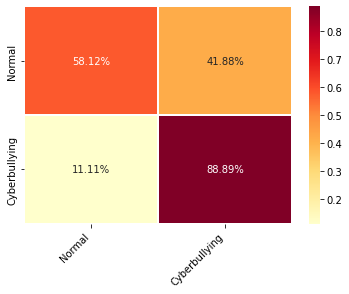

lstm_random_over
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1201
           1       0.22      0.61      0.33        72

    accuracy                           0.86      1273
   macro avg       0.60      0.74      0.62      1273
weighted avg       0.93      0.86      0.89      1273



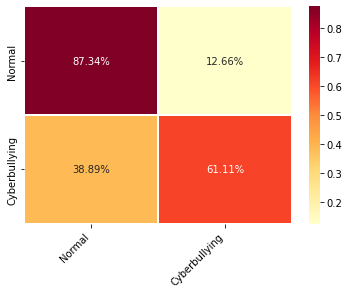

lstm_glove
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1201
           1       0.45      0.50      0.47        72

    accuracy                           0.94      1273
   macro avg       0.71      0.73      0.72      1273
weighted avg       0.94      0.94      0.94      1273



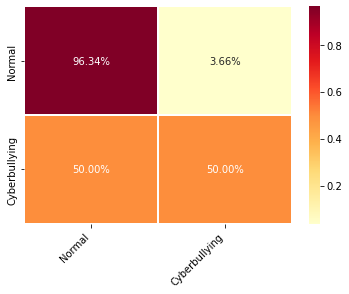

lstm_glove_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1201
           1       0.46      0.51      0.49        72

    accuracy                           0.94      1273
   macro avg       0.72      0.74      0.73      1273
weighted avg       0.94      0.94      0.94      1273



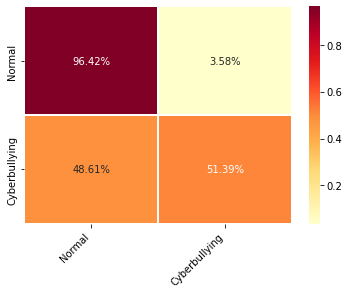

lstm_word2vec
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1201
           1       0.66      0.40      0.50        72

    accuracy                           0.95      1273
   macro avg       0.81      0.70      0.74      1273
weighted avg       0.95      0.95      0.95      1273



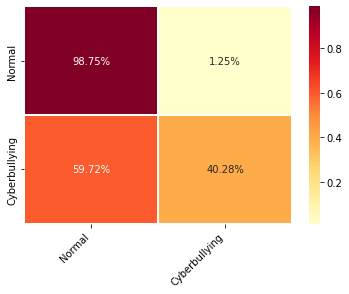

lstm_word2vec_over
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1201
           1       0.59      0.61      0.60        72

    accuracy                           0.95      1273
   macro avg       0.78      0.79      0.79      1273
weighted avg       0.95      0.95      0.95      1273



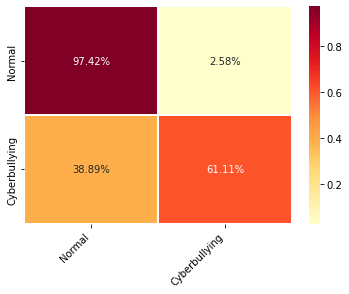

blstm_random
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      1201
           1       0.11      0.64      0.19        72

    accuracy                           0.69      1273
   macro avg       0.54      0.67      0.50      1273
weighted avg       0.92      0.69      0.77      1273



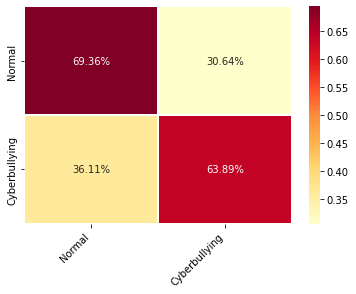

blstm_random_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1201
           1       0.40      0.43      0.42        72

    accuracy                           0.93      1273
   macro avg       0.68      0.70      0.69      1273
weighted avg       0.93      0.93      0.93      1273



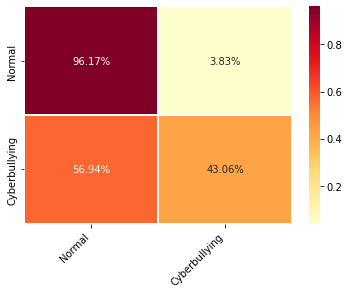

blstm_glove
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1201
           1       0.65      0.44      0.53        72

    accuracy                           0.96      1273
   macro avg       0.81      0.72      0.75      1273
weighted avg       0.95      0.96      0.95      1273



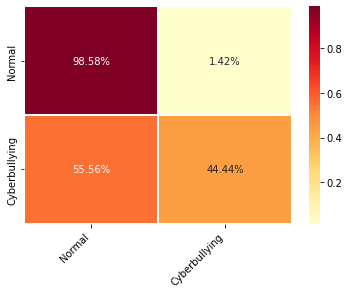

blstm_glove_over
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1201
           1       0.57      0.49      0.53        72

    accuracy                           0.95      1273
   macro avg       0.77      0.73      0.75      1273
weighted avg       0.95      0.95      0.95      1273



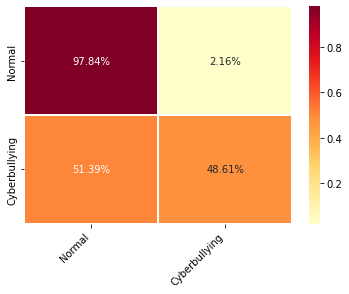

blstm_word2vec
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1201
           1       0.51      0.65      0.57        72

    accuracy                           0.95      1273
   macro avg       0.74      0.81      0.77      1273
weighted avg       0.95      0.95      0.95      1273



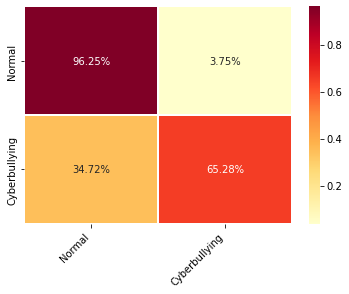

blstm_word2vec_over
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1201
           1       0.54      0.56      0.55        72

    accuracy                           0.95      1273
   macro avg       0.76      0.76      0.76      1273
weighted avg       0.95      0.95      0.95      1273



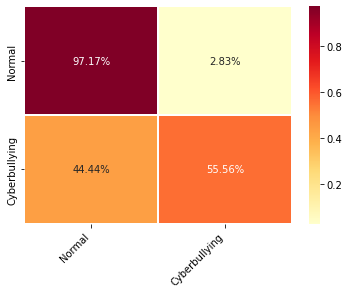

blstm_att_random
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1201
           1       0.38      0.46      0.41        72

    accuracy                           0.93      1273
   macro avg       0.67      0.71      0.69      1273
weighted avg       0.93      0.93      0.93      1273



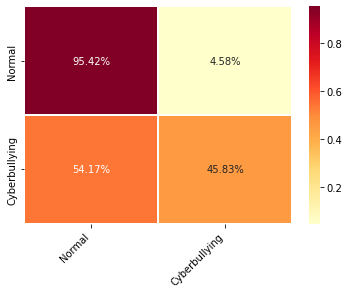

blstm_att_random_over
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1201
           1       0.92      0.15      0.26        72

    accuracy                           0.95      1273
   macro avg       0.93      0.58      0.62      1273
weighted avg       0.95      0.95      0.93      1273



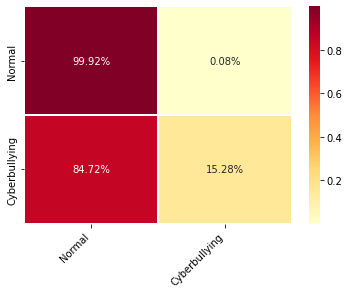

blstm_att_glove
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1201
           1       0.48      0.49      0.48        72

    accuracy                           0.94      1273
   macro avg       0.72      0.73      0.73      1273
weighted avg       0.94      0.94      0.94      1273



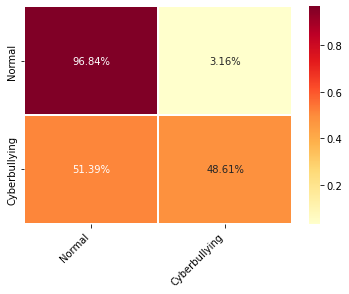

blstm_att_glove_over
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1201
           1       0.44      0.44      0.44        72

    accuracy                           0.94      1273
   macro avg       0.70      0.71      0.70      1273
weighted avg       0.94      0.94      0.94      1273



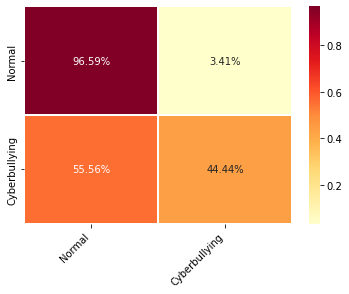

blstm_att_word2vec
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1201
           1       0.56      0.49      0.52        72

    accuracy                           0.95      1273
   macro avg       0.76      0.73      0.75      1273
weighted avg       0.95      0.95      0.95      1273



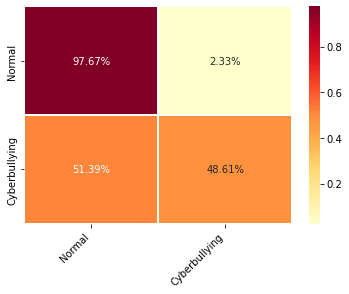

blstm_att_word2vec_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1201
           1       0.46      0.58      0.52        72

    accuracy                           0.94      1273
   macro avg       0.72      0.77      0.74      1273
weighted avg       0.95      0.94      0.94      1273



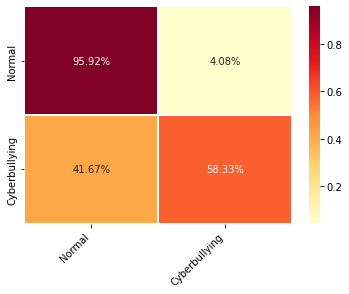

cnn_random
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1201
           1       0.34      0.50      0.41        72

    accuracy                           0.92      1273
   macro avg       0.66      0.72      0.68      1273
weighted avg       0.93      0.92      0.92      1273



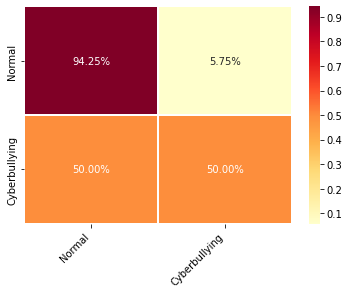

cnn_random_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1201
           1       0.42      0.44      0.43        72

    accuracy                           0.93      1273
   macro avg       0.69      0.70      0.70      1273
weighted avg       0.94      0.93      0.93      1273



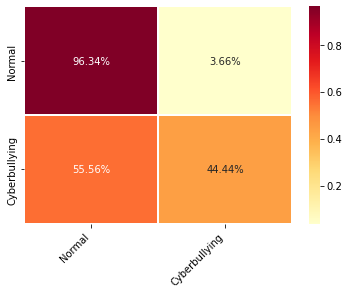

cnn_glove
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1201
           1       0.67      0.31      0.42        72

    accuracy                           0.95      1273
   macro avg       0.81      0.65      0.70      1273
weighted avg       0.94      0.95      0.94      1273



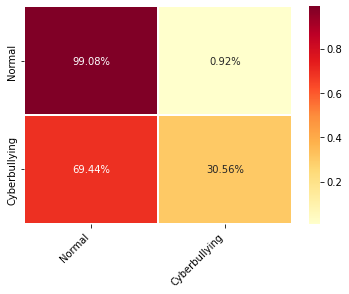

cnn_glove_over
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1201
           1       0.57      0.44      0.50        72

    accuracy                           0.95      1273
   macro avg       0.77      0.71      0.74      1273
weighted avg       0.94      0.95      0.95      1273



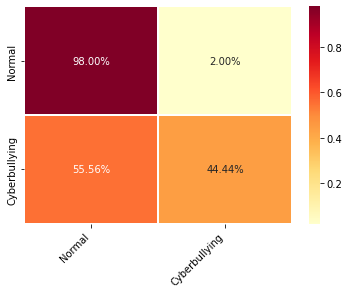

cnn_word2vec
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1201
           1       0.90      0.39      0.54        72

    accuracy                           0.96      1273
   macro avg       0.93      0.69      0.76      1273
weighted avg       0.96      0.96      0.96      1273



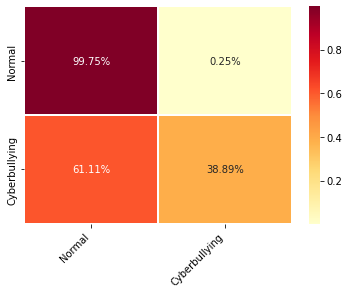

cnn_word2vec_over
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1201
           1       0.55      0.53      0.54        72

    accuracy                           0.95      1273
   macro avg       0.76      0.75      0.76      1273
weighted avg       0.95      0.95      0.95      1273



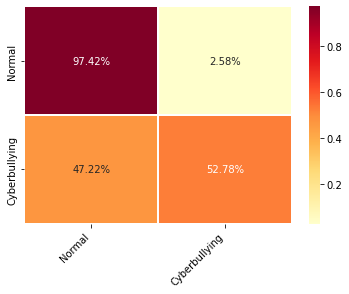

In [46]:
predictions = []

for model in model_list:
    index = model_list.index(model)
    print(model_name_list[index])
    model_prediction = indiv_eval(model, X_test, y_test)
    predictions.append(model_prediction)

In [47]:
import joblib
joblib.dump(predictions, 'formspring_dl_preds.df')

['formspring_dl_preds.df']

In [48]:
multiple_mcnemar(model_name_list, predictions, y_test, 0.01)

+-------------------------+-------------------------+-----------+-----------+---------+
|         Model 1         |         Model 2         |    Chi²   |  p-Value  | Reject? |
+-------------------------+-------------------------+-----------+-----------+---------+
|       lstm_random       |     lstm_random_over    | 2.87E+02f | 1.89E-64f |   True  |
|       lstm_random       |        lstm_glove       | 3.63E+02f | 5.49E-81f |   True  |
|       lstm_random       |     lstm_glove_over     | 3.73E+02f | 5.34E-83f |   True  |
|       lstm_random       |      lstm_word2vec      | 3.88E+02f | 2.66E-86f |   True  |
|       lstm_random       |    lstm_word2vec_over   | 4.05E+02f | 4.10E-90f |   True  |
|       lstm_random       |       blstm_random      | 6.14E+01f | 4.56E-15f |   True  |
|       lstm_random       |    blstm_random_over    | 3.64E+02f | 4.46E-81f |   True  |
|       lstm_random       |       blstm_glove       | 3.92E+02f | 3.67E-87f |   True  |
|       lstm_random       |     